Load the needed libraries.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import numpy as np 
import os
import pandas as pd
import seaborn as sn
import cv2
from random import randint
import PIL
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.transforms as tt
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
%matplotlib inline

Read the direcrtory of the gemstone image dataset and format the data.

Output: gemstone image class names, sample images and corresponding index of class names in nparray.

In [2]:
# define the image width and image height
width, height = 128, 128


# read the folder and get gemstone class names and index
def read_imgs_lbls(_dir):
    class_name, Images, Labels = [], [], []
    class_cnt = -1
    for root, dirs, img_files in os.walk(_dir):
        folder_name = os.path.basename(root) 
        if folder_name and folder_name not in class_name:
            # add class name (folder name)
            class_name.append(folder_name)
            class_cnt+=1
        for file in img_files:
            Labels.append(class_cnt)
            try:
                # read the image with OpenCV
                image = cv2.imread(root+'/'+file)   
                # resize the image (images are different sizes)
                image = cv2.resize(image,(int(width*1.5), int(height*1.5)))  
                # converts an image from BGR color space to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
                Images.append(image)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    Labels = np.array(Labels)
    return (class_name, Images, Labels)

In [3]:
# the file direction of training data
training_dir = '/kaggle/input/train/'
# certificate the shape of training images and labels
class_name, training_Imgs, training_Lbls = read_imgs_lbls(training_dir)
# , training_Lbls = get_class_index(training_Lbls)
print("Number of classes: ", len(class_name))
# print(class_name)
# print(training_Lbls)
print('training images: ', training_Imgs.shape)
print('training labels: ', training_Lbls.shape)

Number of classes:  87
training images:  (2856, 192, 192, 3)
training labels:  (2856,)


1. Get edge pixels of the gemstone with Canny.

2. Get the top left and bottom right points of the edge, and generate a bounding box with those two points.

3. Cut off the bounding box and resize the image.

In [5]:
# show how Canny works
def show_cropped(img, lower, upper):
    # execute Canny algorithm and get the bounding box 
    edg_img = img.copy()
    edges = cv2.Canny(img, lower, upper)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        new_img = img[y1:y2, x1:x2]  
        # To protect the details around the gemstone edge, replace it with bigger size for larger images  
        edge_size = 2           
        # draw the bounding box edge
        edg_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        edg_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        edg_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        edg_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]
        # Convert to primary size 
        new_img = cv2.resize(new_img,(width, height))  
        
    else:
        new_img = cv2.resize(img,(width, height))
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    # show the original image
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    # show the Canny result
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Result', fontsize=14)
    # show the bounding box
    ax[2].imshow(edg_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14) 
    # show the cut image
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped Image', fontsize=14)   

86


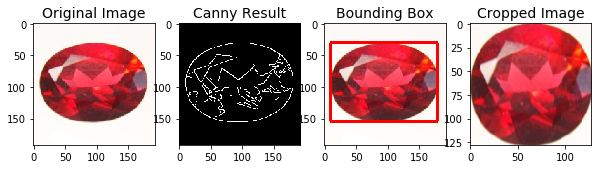

In [6]:
t = randint(0,len(training_Imgs))
print(t)
show_cropped(training_Imgs[t],128,200)

We intend to completely remove the influence of the matt background, but at last we do not remove all matt backgrounds.

The second and third parameter of cv.Canny(image, minVal, maxVal) define the minVal and maxVal to check whether a pixel is the edge or not. According to the theory in chapter XXX, the larger parameters are, the more seriously to extract the edge pixels. The output of different minVal and maxVal is below.


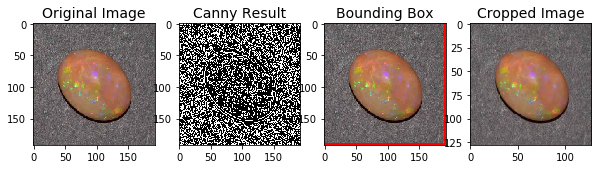

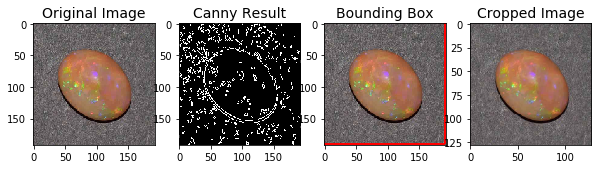

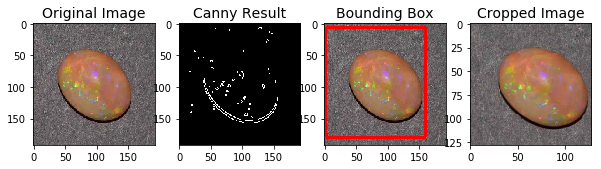

In [7]:
show_cropped(training_Imgs[2770], 10,20)
show_cropped(training_Imgs[2770], 100,200)
show_cropped(training_Imgs[2770], 200,300)

From those output, we can see that if the parameters are too small, the matt background is not likely to detect. However, when the parameters are big enough, Canny can easily cut off the background without the effect the background texture. What is more, if the gemstone is too smooth but the background is rough, Canny cannot detect its edge. In addition, if the gemstone has similar color with the background (the derivative is too small to be an edge), Canny may cut the gemstones and lose some details (shape, highlight, texture, etc) of the gemstone. 

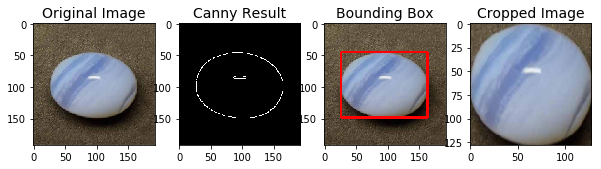

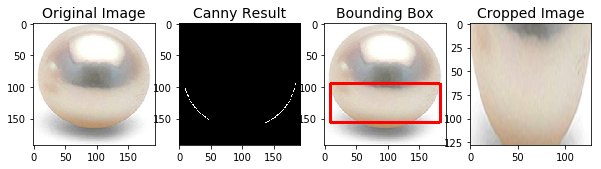

In [8]:
show_cropped(training_Imgs[137], 200,300)
show_cropped(training_Imgs[356], 200,300)

Most gemstones have similar shape and texture, like pearls or turquoise, so we are more willing to protect the details of gemstones instead of cut all background, so we choose minVal = 128 and maxVal=200. Those parameters can cut a little more background without cut off the details. Thus, we cannot remove all matt backgrounds.

Then we crop all images with the chosen parameters.

In [4]:
# cut the images with Canny
def cut_by_edge(img):
    try:
        # get the edges of the gemstone
        edges = cv2.Canny(img, 128, 200)            
        # get the bounding box catching the gemstone
        if(np.count_nonzero(edges)>edges.size/10000):
            # get the position of edge points
            pts = np.argwhere(edges>0)
            # get the top-left point
            y1,x1 = pts.min(axis=0)
            # get the bottom-right point
            y2,x2 = pts.max(axis=0)
            # crop the bounding box
            new_img = img[y1:y2, x1:x2]
            # Convert back to the original shape
            new_img = cv2.resize(new_img,(width, height))  
        else:
            new_img = cv2.resize(img,(width, height))
    # if Canny does not success, resize the image to the original size
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(width, height))
    
    return new_img

In [9]:
# crop the images in the training dataset. The cropped image dataset should be (2856, 128, 128, 3)
def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), width, height, 3), dtype=np.int)

    ind = 0
    for im in Imgs: 
        x = cut_by_edge(im)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages
training_Imgs = crop_images(training_Imgs)

Next, we prepare cuda to train our network.

In [10]:
# check is the GPU is available
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
# move the images to the GPU   
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        res = []
        for x in data:
            res.append(to_device(x, device))
        return res
    return data.to(device, non_blocking=True)
# move the dataloader to GPU
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)
    
device = get_device()
device


device(type='cuda')

Transform RGB images to tensor images with shape (2856, 3, 128, 128)

In [11]:
# transform RGB images to tensor images with shape (2856, 3, 128, 128)
temp = np.empty([2856, 3, 128, 128], dtype = float) 
for i in range(2856):
    for m in range(3):
        for j in range(128):
            for k in range(128):
                temp[i][m][j][k] = training_Imgs[i][j][k][m]/255.0

In [12]:
from torch.utils.data import TensorDataset, DataLoader
# transform nparray to torch tensor
tensor_x = torch.from_numpy(temp) 
tensor_y = torch.from_numpy(training_Lbls)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
# my_dataset =  experimental_dataset(dataset,tt)
my_dataloader = DataLoader(my_dataset) # create your dataloader

In [13]:
# training set : validation set = 8 : 2
val_ds_size = int(len(my_dataset) * 0.2)
train_ds_size = len(my_dataset) - val_ds_size
train_ds, val_ds = random_split(my_dataset, [train_ds_size, val_ds_size])
len(train_ds), len(val_ds)

(2285, 571)

torch.Size([3, 128, 128])
tensor(68)


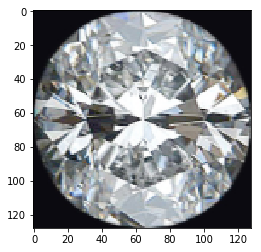

In [14]:
# show a random image to check if the dataset is available
images, labels = my_dataset[randint(0, len(my_dataset))]
print(images.size())
plt.imshow(images.permute(1,2,0))
print(labels)

In [15]:
# define the training and validation dataloader
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

Besides, the model we will use is AlexNet, which contains several relatively new technical points:

(1) Successfully use ReLU as the activation function of CNN, and verify that its effect surpasses Sigmoid in a deeper network, and successfully solves the gradient dispersion problem of Sigmoid when the network is deeper.

(2) Use Dropout to randomly ignore some neurons during training to avoid model overfitting.

(3) Use overlapping maximum pooling in CNN to avoid the blurring effect of average pooling. And AlexNet proposes to make the step size smaller than the size of the pooling core, so that there will be overlap and coverage between the outputs of the pooling layer, which improves the richness of features.

(4) The LRN layer is proposed to create a competition mechanism for the activity of local neurons, so that the value with a larger response becomes relatively larger, and other neurons with smaller feedback are inhibited, which enhances the generalization ability of the model.

(5) Use CUDA to accelerate the training of deep convolutional networks, and use the powerful parallel computing capabilities of GPU to process a large number of matrix operations during neural network training.

(6) Data enhancement can greatly reduce over-fitting and improve generalization ability. When making predictions.

The input is the resized image without background, and it go through 8 layers in AlexNet: five convolutional layers (some of them followed by max-pooling layers), and three full connect layers. The output it the predict classification of 87 classes.


In [18]:
alexnet = models.alexnet()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Train and validate the model by step, using the cross entropy as the loss function.

In [17]:
# output the validation batch accuracy
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# define the classification model
class Classification_model(nn.Module):
    
    # train the model by step, using the cross entropy as the loss function
    def training_step(self, batch):
        images, labels = batch
        out = self(images.float())
        loss = F.cross_entropy(out, labels)
        return loss
    
    # validate the model by step, get the loss and accuracy of each batch
    def validation_step(self, batch):
        images, labels = batch
        out = self(images.float())
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}
    
    # get the average loss and accuracy
    def validation_epoch_end(self, outputs):
        batch_loss = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    # print train_loss, val_loss and result
    def epoch_end(self, epoch, result):
        print("Epoch: ", epoch+1)
        print("Learning rate: ", result["lrs"][-1])
        print("Training loss: ", result["train_loss"])
        print("Validation loss: ",result["val_loss"])
        print("Validation accuracy: ", result["val_acc"])
        print("\n")

In [19]:
# define the network
class Alexnet_gems(Classification_model):
    def __init__(self):
        super().__init__()
        self.network = models.alexnet(pretrained=True)
        
        # reset the last fully connected layer to be able to classficate 87 kinds of gemstones
        number_of_features = self.network.classifier[6].in_features
        self.network.classifier[6] = nn.Linear(number_of_features, 87)
        
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad = False
            
        # only the FC layer require grad
        for param in self.network.classifier[6].parameters():
            param.require_grad = True
            
    def unfreeze(self):
        # all parameters require grad
        for param in self.network.parameters():
            param.require_grad = True

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [21]:
@torch.no_grad()

# get val_loss and val_acc
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

# get the learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

# training the network for all epochs with Adam optimizer, output the training loss.
def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=None, 
                  grad_clip=0, opt_func=torch.optim.Adam):
    
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in tqdm(train_dl):
            # get the training loss and go backward
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            # grad clipping: to avoid exploding gradient
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
        result = evaluate(model, val_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
model = to_device(Alexnet_gems(), device)
history = [evaluate(model, val_dl)]
history

[{'val_loss': 4.8805999755859375, 'val_acc': 0.006514830980449915}]

We first train the top-level classifier, for instance we should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. 


In [23]:
# freeze and train the FC layer with decayed learning rate
# we first train the top-level classifier, 
# for instance we should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. 
# This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. 
model.freeze()
epochs = 10
max_lr = 10e-5
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                        grad_clip=grad_clip, weight_decay=weight_decay,
                        opt_func=opt_func)


Epoch:  1
Learning rate:  2.7190982402008296e-05
Training loss:  4.633238792419434
Validation loss:  4.278050899505615
Validation accuracy:  0.06851164996623993





Epoch:  2
Learning rate:  7.559202360223044e-05
Training loss:  3.417454719543457
Validation loss:  2.147716522216797
Validation accuracy:  0.42251056432724





Epoch:  3
Learning rate:  0.0001
Training loss:  1.513239860534668
Validation loss:  1.4553025960922241
Validation accuracy:  0.5826801061630249





Epoch:  4
Learning rate:  9.504846320134737e-05
Training loss:  0.8151907324790955
Validation loss:  1.0862624645233154
Validation accuracy:  0.6858580708503723





Epoch:  5
Learning rate:  8.117456539497631e-05
Training loss:  0.4876302182674408
Validation loss:  1.1125465631484985
Validation accuracy:  0.6897775530815125





Epoch:  6
Learning rate:  6.112620219362893e-05
Training loss:  0.28597891330718994
Validation loss:  1.070482850074768
Validation accuracy:  0.6991525888442993





Epoch:  7
Learning rate:  3.8874197806371076e-05
Training loss:  0.16664332151412964
Validation loss:  1.0182716846466064
Validation accuracy:  0.7275424003601074





Epoch:  8
Learning rate:  1.88258346050237e-05
Training loss:  0.08993706852197647
Validation loss:  1.0341390371322632
Validation accuracy:  0.7194650769233704





Epoch:  9
Learning rate:  4.9519367986526286e-06
Training loss:  0.05516674742102623
Validation loss:  0.9905468821525574
Validation accuracy:  0.7259799242019653





Epoch:  10
Learning rate:  3.9999999999999996e-10
Training loss:  0.04717331752181053
Validation loss:  0.9934398531913757
Validation accuracy:  0.7259799242019653




In [24]:
# unfreeze and train the whole model with decayed learning rate
model.unfreeze()
epochs = 10
max_lr = 0.0005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                        grad_clip=grad_clip, weight_decay=weight_decay,
                        opt_func=opt_func)


Epoch:  1
Learning rate:  0.00013595491201004141
Training loss:  0.11400685459375381
Validation loss:  1.2232874631881714
Validation accuracy:  0.7051377296447754





Epoch:  2
Learning rate:  0.0003779601180111522
Training loss:  0.6253694891929626
Validation loss:  1.661159873008728
Validation accuracy:  0.533739447593689





Epoch:  3
Learning rate:  0.0005
Training loss:  1.1816242933273315
Validation loss:  1.6562480926513672
Validation accuracy:  0.5253972411155701





Epoch:  4
Learning rate:  0.0004752423160067368
Training loss:  0.7762914299964905
Validation loss:  1.6054691076278687
Validation accuracy:  0.5814088582992554





Epoch:  5
Learning rate:  0.0004058728269748815
Training loss:  0.5146331787109375
Validation loss:  1.440348744392395
Validation accuracy:  0.6173464059829712





Epoch:  6
Learning rate:  0.0003056310109681446
Training loss:  0.2836065888404846
Validation loss:  1.2605146169662476
Validation accuracy:  0.6668432354927063





Epoch:  7
Learning rate:  0.00019437098903185538
Training loss:  0.13517645001411438
Validation loss:  1.253782868385315
Validation accuracy:  0.6835275888442993





Epoch:  8
Learning rate:  9.412917302511849e-05
Training loss:  0.06243937090039253
Validation loss:  1.1936619281768799
Validation accuracy:  0.7166048884391785





Epoch:  9
Learning rate:  2.4759683993263143e-05
Training loss:  0.020000139251351357
Validation loss:  1.1861529350280762
Validation accuracy:  0.7309321761131287





Epoch:  10
Learning rate:  2e-09
Training loss:  0.012172463349997997
Validation loss:  1.1860988140106201
Validation accuracy:  0.7309321761131287




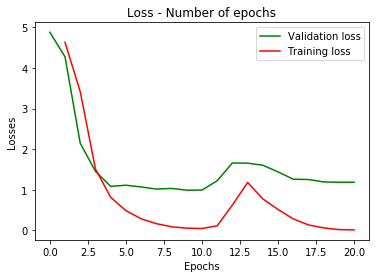

In [25]:
# plot the training and valid loss
def plot_losses(history):
    val_loss = [x["val_loss"] for x in history]
    train_loss = [x.get("train_loss") for x in history]
    plt.plot(val_loss, "-g")
    plt.plot(train_loss, "-r")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend(["Validation loss", "Training loss"])
    plt.title("Loss - Number of epochs")
    
plot_losses(history)

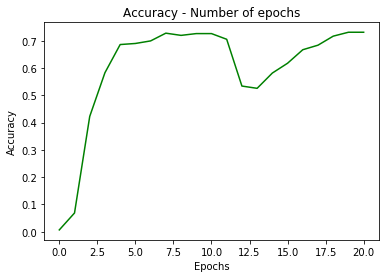

In [26]:
# plot the validation accuracy
def plot_accuracy(history):
    accuracy = [x["val_acc"] for x in history]
    plt.plot(accuracy, "-g")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy - Number of epochs")
    
plot_accuracy(history)

In [27]:
# predict one image
def prediction(images, model):
    xb = to_device(images.unsqueeze(0), device)
    out = model(xb)
    _,preds = torch.max(out, dim=1)
    prediction = preds[0].item()
    return prediction

In [28]:
# load the test data
class_names, test_Imgs, test_Lbls = read_imgs_lbls("/kaggle/input/test/")
print('Test images: ', test_Imgs.shape)
print('Test labels: ', test_Lbls.shape)

# crop the test images
test_Imgs = crop_images(test_Imgs)
print('Final shape of images in test set: ', test_Imgs.shape)

Test images:  (363, 192, 192, 3)
Test labels:  (363,)
Final shape of images in test set:  (363, 128, 128, 3)


In [29]:
# transform RGB images to tensor images and reshape
temp_test = np.empty([363, 3, 128, 128], dtype = float) 
for i in range(363):
    for m in range(3):
        for j in range(128):
            for k in range(128):
                temp_test[i][m][j][k] = test_Imgs[i][j][k][m]/255

In [30]:
# transform nparray to torch tensor
tensor_x = torch.from_numpy(temp_test) 
tensor_y = torch.from_numpy(test_Lbls)
y_test = []
y_pred = []
dataset = TensorDataset(tensor_x,tensor_y) 
# dataset = experimental_dataset(tensor_x,tt)
for i in range(len(dataset)):
    img, label = dataset[i]
    # print(label)
    y_test.append(label)
    # print()
    y_pred.append(prediction(img.float(), model))

We use heat map to analysis the results of different class of gemstones. 

At first, we determine the numbers of training and test samples with the bar plot. It shows that the number of test samples of each class is not the same, so we use a proportion heat map to show the results.

Text(0.5, 0, 'gemstone classes')

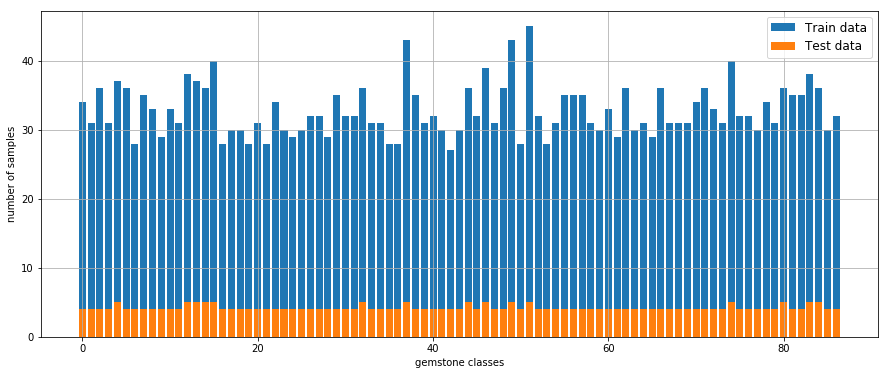

In [31]:
gem_num = []
# get class name (87 classes)
for root, dirs, im in os.walk('/kaggle/input'):
    folder_name = os.path.basename(root)        
        
    if len(im) > 0:
        # get count of images for each class
        gem_num.append(len(im))
        # get genmstone classes  

# show the count of training data and test data
gems_count = len(class_name) 
f, ax = plt.subplots(figsize=(15,6))
if(gem_num[0])<10:
    plt.bar(range(gems_count), gem_num[gems_count:], label = 'Train data')
    plt.bar(range(gems_count), gem_num[0:gems_count], label = 'Test data')
else:
    plt.bar(range(gems_count), gem_num[0:gems_count], label = 'Train data')
    plt.bar(range(gems_count), gem_num[gems_count:], label = 'Test data')
ax.grid()
ax.legend(fontsize = 12);
plt.ylabel("number of samples")
plt.xlabel("gemstone classes")

In [32]:
# show the heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(30, 30))
cm = confusion_matrix(y_test, y_pred)
temp = np.zeros(shape=(87,87))

for i in range(87):
    true = 0
    for j in range(87):
        true += cm[i][j]
    # print(cm[i][0])
    # print(true)
    for k in range(87):
        temp[i][k]=cm[i][k]/true

<Figure size 2160x2160 with 0 Axes>

Most class has the correct ratio over 0.5, which is a lot larger than 1/87. It indicates that our network is able to classify the gemstone images. However, our network does not do well on some of the gemstone classes. 

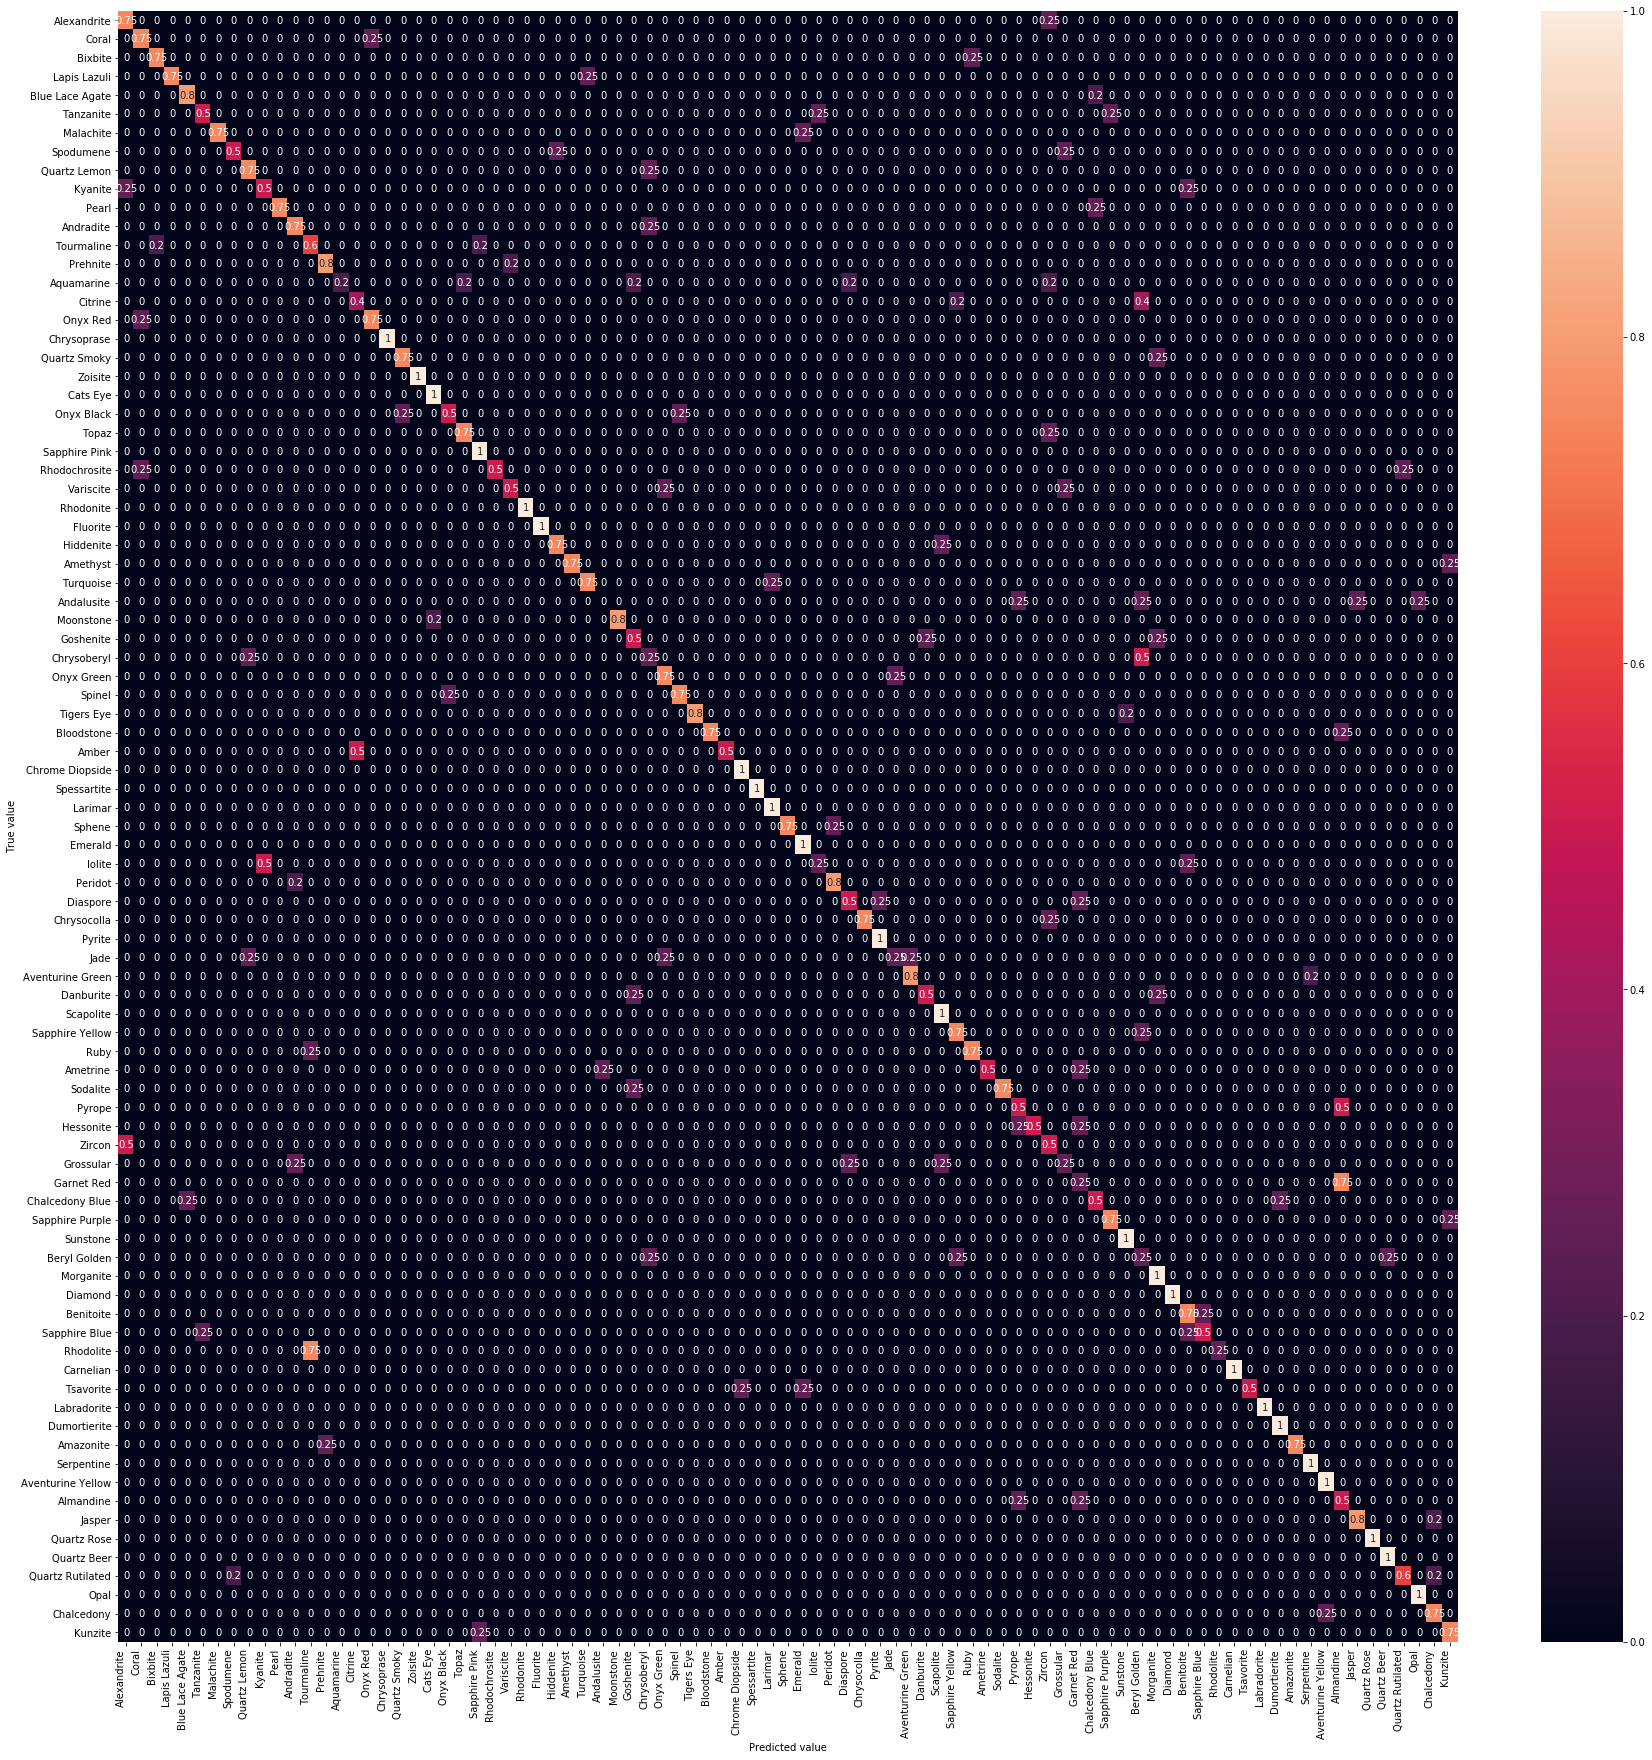

In [33]:
plt.figure(figsize = (30,30))
df_cm = pd.DataFrame(temp, index=class_name, columns=class_name)
heat = sn.heatmap(df_cm, annot=True)
heat.yaxis.set_ticklabels(heat.yaxis.get_ticklabels(), rotation=0, ha='right')
heat.xaxis.set_ticklabels(heat.xaxis.get_ticklabels(), rotation=90, ha='right')
plt.ylabel('True value')
plt.xlabel('Predicted value');

For example, an almandine is likely to be regarded as a garnet red, because they are both red angular and reflect bright light. Most mistakes are caused by similarity, such as rhodolites and tourmalines. There are 3 of 4 rhodolites regarded as tourmalines.